In [11]:
import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
ascii_files = glob.glob('*ASC*')
ascii_files

['example_ASC.TXT',
 'gb-long_2016-08-24_0_000_ASC.TXT',
 'gb-long_2016-08-24_0_001_ASC.TXT']

In [4]:
columns = ['datetime', 'ensemble_number', 'number_of_ensembles', 
           'pitch', 'roll', 'corrected_heading', 'adcp_temp']
columns += ['v_bt_x', 'v_bt_y', 'v_bt_z', 'v_bt_err', 
            'depth_snd', 'gga_alt', 'gga_dalt', 'gga_hdop',
            'depth_beam1', 'depth_beam2', 'depth_beam3', 'depth_beam4']
columns += ['total_elapsed_dist', 'total_elapsed_time', 'total_dist_n', 'total_dist_e', 'total_dist_mg']
columns += ['lat', 'lon', 'invalid', 'fixed_value_not_used']
columns += ['Q_middle', 'Q_top', 'Q_bot', 
            'start_shore_dist_est', 'start_dist', 'end_shore_dist_est', 'end_dist',
            'start_depth', 'end_depth']
columns += ['nbins', 'unit', 'vel_ref', 'intensity_units', 'intensity_scale_fac', 'sound_abs_fac']
columns

['datetime',
 'ensemble_number',
 'number_of_ensembles',
 'pitch',
 'roll',
 'corrected_heading',
 'adcp_temp',
 'v_bt_x',
 'v_bt_y',
 'v_bt_z',
 'v_bt_err',
 'depth_snd',
 'gga_alt',
 'gga_dalt',
 'gga_hdop',
 'depth_beam1',
 'depth_beam2',
 'depth_beam3',
 'depth_beam4',
 'total_elapsed_dist',
 'total_elapsed_time',
 'total_dist_n',
 'total_dist_e',
 'total_dist_mg',
 'lat',
 'lon',
 'invalid',
 'fixed_value_not_used',
 'Q_middle',
 'Q_top',
 'Q_bot',
 'start_shore_dist_est',
 'start_dist',
 'end_shore_dist_est',
 'end_dist',
 'start_depth',
 'end_depth',
 'nbins',
 'unit',
 'vel_ref',
 'intensity_units',
 'intensity_scale_fac',
 'sound_abs_fac']

In [5]:
df_cols = ['depth', 'vmag', 'vdir', 'vx', 'vy', 'vz', 'verr', 'bs1', 'bs2', 'bs3', 'bs4', 'pctg', 'Q']

In [8]:
def parse_header(f):
    row1 = next(f).strip().split()
    row1[0] = '20' + row1[0] if '20' not in row1[0] else row1[0]
    dt = pd.datetime(*tuple(map(int, row1[:6])), int(int(row1[6]) * 1e4))
    dt64 = np.datetime64(dt)
    ensemble_number, ne = map(int, row1[7:9])

    data = [dt] + [ensemble_number, ne] + list(map(float, row1[9:]))
    for i in range(4):
        data += list(map(float, next(f).strip().split()))
    row6 = next(f).strip().split()
    nbins = int(row6[0])
    data += row6[1:4]
    data += list(map(float, row6[4:]))
    return ensemble_number, data, nbins, dt

def ascii2pd(ascii_file, make_geometries=False):
    f = open(ascii_file)
    while True:
        line = next(f).strip().split()
        if len(line) == 0:
            continue
        else:
            break
    file_info = map(int, line)
    depth_cell_len, blank_after_transmit, adcp_depth_from_cn, n_depth_cells, n_pings, dt, mode = file_info
    
    data = {}
    dfs = {}
    
    try:
        while True:
            n, d, nbins, dt = parse_header(f)
            data[n] = d
            df = pd.DataFrame([map(float, next(f).strip().split()) for b in range(nbins)], columns=df_cols)
            dfs[dt] = df
    except StopIteration:
        pass
    
    df = pd.DataFrame.from_dict(data, orient='index')
    df.columns = columns
    df.index = pd.to_datetime(df.datetime)

    if make_geometries:
        df['geometry'] = [Point(r.lon, r.lat) for i, r in df.iterrows()]
        df['geometry'] = projectdf(df, '+init=epsg:4269', '+init=epsg:26715')
        df['X'] = [p.x for p in df.geometry]
        df['Y'] = [p.y for p in df.geometry]
    else:
        df['X'] = df.lon
        df['Y'] = df.lat
    
    # make a data panel of the velocity data
    pn = pd.Panel(dfs)
    return df, pn

def stack(df, pn, vmin, vmax, freq, make_geometries=False):
    pnr = pn.dropna(axis=1, how='all').resample(freq, axis=0).mean().copy()

    inds = (pnr.ix[:, :, 'vx'].values < vmin) | (pnr.ix[:, :, 'vx'].values > vmax)
    pnrs = pnr.copy()
    pnrs.ix[:, :, 'vx'].mask(inds, inplace=True)
    pnrs.ix[:, :, 'vy'].mask(inds, inplace=True)

    dfr = df[['X', 'Y', 'datetime']].resample(freq).mean()
    if make_geometries:
        dfr['geometry'] = [Point(r.X, r.Y) for i, r in dfr.iterrows()]
    dfr['vx'] = pnrs.ix[:, :, 'vx'].mean()
    dfr['vy'] = pnrs.ix[:, :, 'vy'].mean()
    dfr.dropna(axis=0, inplace=True)
    return dfr

In [9]:
outpath = 'output'
if not os.path.isdir(outpath):
    os.makedirs(outpath)

for ascii_file in ascii_files:
    if os.path.getsize(ascii_file) == 0:
        continue
    print(ascii_file)
    df, pn = ascii2pd(ascii_file)
    dfr = stack(df, pn, vmin=-1000, vmax=1000, freq='10s')

example_ASC.TXT
gb-long_2016-08-24_0_000_ASC.TXT
gb-long_2016-08-24_0_001_ASC.TXT


In [23]:
pn.axes

[DatetimeIndex(['2016-08-24 18:26:45.850000', '2016-08-24 18:26:46.430000',
                '2016-08-24 18:26:47.010000', '2016-08-24 18:26:47.590000',
                '2016-08-24 18:26:48.170000', '2016-08-24 18:26:48.750000',
                '2016-08-24 18:26:49.330000', '2016-08-24 18:26:49.910000',
                '2016-08-24 18:26:50.490000', '2016-08-24 18:26:51.070000',
                ...
                '2016-08-24 20:38:52.820000', '2016-08-24 20:38:53.410000',
                       '2016-08-24 20:38:54', '2016-08-24 20:38:54.580000',
                '2016-08-24 20:38:55.170000', '2016-08-24 20:38:55.760000',
                '2016-08-24 20:38:56.350000', '2016-08-24 20:38:56.940000',
                '2016-08-24 20:38:57.530000', '2016-08-24 20:38:58.130000'],
               dtype='datetime64[ns]', length=13477, freq=None),
 RangeIndex(start=0, stop=26, step=1),
 Index(['depth', 'vmag', 'vdir', 'vx', 'vy', 'vz', 'verr', 'bs1', 'bs2', 'bs3',
        'bs4', 'pctg', 'Q'],
      

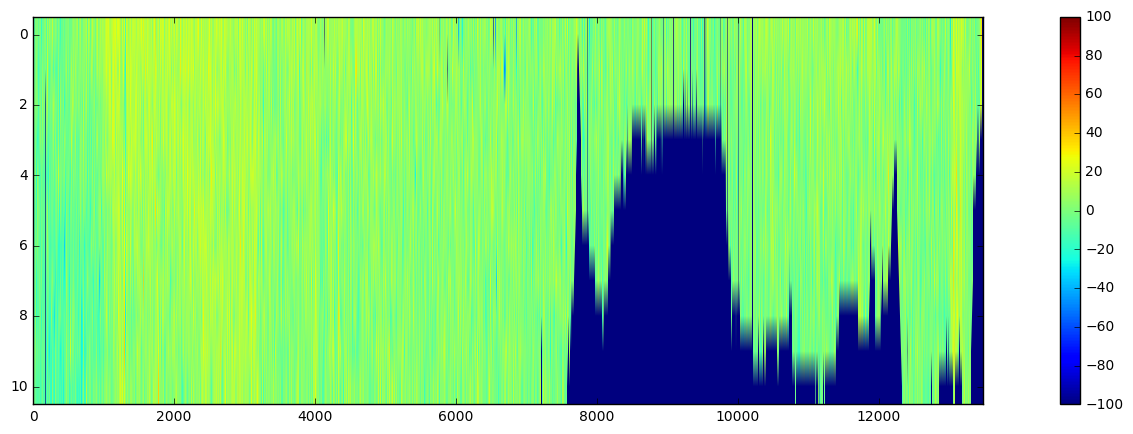

In [12]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(pn.ix[:, :10, 'vy'], vmin=-100, vmax=100)
plt.gca().set_aspect(500)
plt.colorbar()

### process single ADCP panel

In [20]:
vmin, vmax = -1000, 1000 # valid range of velocities
freq = '10s' # resampling frequency

pnr = pn.dropna(axis=1, how='all').resample(freq, axis=0).mean().copy()

inds = (pnr.ix[:, :, 'vx'].values < vmin) | (pnr.ix[:, :, 'vx'].values > vmax)
pnrs = pnr.copy()
pnrs.ix[:, :, 'vx'].mask(inds, inplace=True)
pnrs.ix[:, :, 'vy'].mask(inds, inplace=True)

In [15]:
bs = pnr.ix[:, :10, ['bs1', 'bs2', 'bs3', 'bs4']].mean(axis=2)
bs = pn.ix[:, :10, ['bs1', 'bs2', 'bs3', 'bs4']].mean(axis=2)
bs.head()

,2016-08-24 18:26:45.850000,2016-08-24 18:26:46.430000,2016-08-24 18:26:47.010000,2016-08-24 18:26:47.590000,2016-08-24 18:26:48.170000,2016-08-24 18:26:48.750000,2016-08-24 18:26:49.330000,2016-08-24 18:26:49.910000,2016-08-24 18:26:50.490000,2016-08-24 18:26:51.070000,...,2016-08-24 20:38:52.820000,2016-08-24 20:38:53.410000,2016-08-24 20:38:54,2016-08-24 20:38:54.580000,2016-08-24 20:38:55.170000,2016-08-24 20:38:55.760000,2016-08-24 20:38:56.350000,2016-08-24 20:38:56.940000,2016-08-24 20:38:57.530000,2016-08-24 20:38:58.130000
0,83.650,83.650,84.075,83.65,83.850,83.550,83.225,84.100,83.425,83.025,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,83.8,83.925
1,84.900,85.425,85.650,85.00,85.675,85.550,85.100,85.550,85.425,85.125,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.000
2,85.125,85.350,85.450,84.90,85.225,85.475,85.475,85.100,85.125,85.150,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.000
3,84.825,84.800,84.900,84.50,85.775,84.900,84.800,84.900,84.700,84.300,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.000
4,84.100,84.100,83.975,83.95,86.025,83.650,83.975,83.525,83.650,83.550,...,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.0,255.000


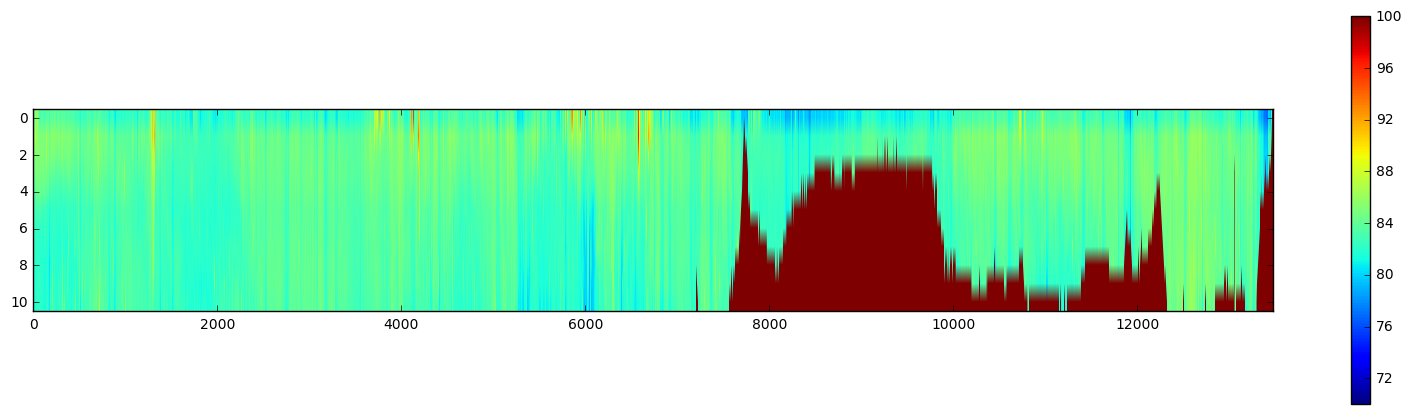

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(bs, vmin=70, vmax=100)
plt.gca().set_aspect(200)
plt.colorbar()

### Plot velocity component across panel

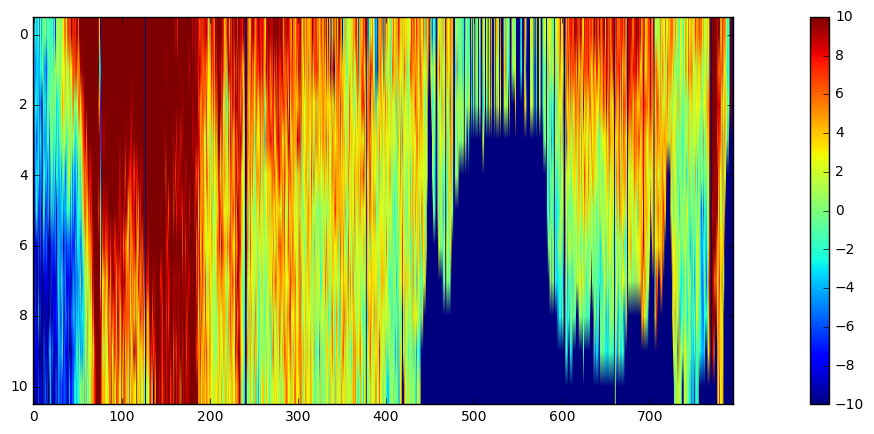

In [17]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(pnr.ix[:, :10, 'vy'], vmin=-10, vmax=10)
plt.gca().set_aspect(40)
plt.colorbar()

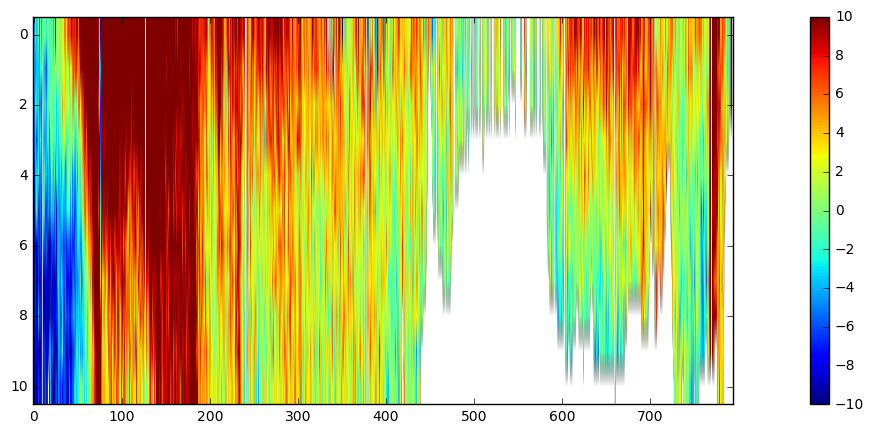

In [21]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.imshow(pnrs.ix[:, :10, 'vy'], vmin=-10, vmax=10)
plt.gca().set_aspect(40)
plt.colorbar()

### Slice panel to get dataframe of single measurement

In [24]:
pn.ix['2016-08-24 18:26:45.85', :, :]

,depth,vmag,vdir,vx,vy,vz,verr,bs1,bs2,bs3,bs4,pctg,Q
0,1.38,13.58,46.25,9.8,9.4,-6.6,-11.0,86.2,84.1,81.9,82.4,100.0,2.147484e+09
1,1.88,10.47,118.58,9.2,-5.0,-2.0,5.6,86.5,84.8,83.5,84.8,100.0,2.147484e+09
2,2.38,8.04,300.77,-6.9,4.1,-2.3,2.7,87.2,84.6,83.7,85.0,100.0,2.147484e+09
3,2.88,8.96,244.17,-8.1,-3.9,0.4,7.0,87.0,84.8,83.1,84.4,100.0,2.147484e+09
4,3.38,3.42,196.34,-1.0,-3.3,-2.4,3.6,86.0,83.9,82.6,83.9,100.0,2.147484e+09
5,3.88,10.85,169.69,1.9,-10.7,-0.2,5.5,83.9,83.1,81.4,83.1,100.0,2.147484e+09
6,4.38,3.84,150.97,1.9,-3.4,-0.7,17.9,84.1,82.8,81.1,82.0,100.0,2.147484e+09
7,4.88,3.39,144.63,2.0,-2.8,2.4,8.9,83.9,82.1,80.4,81.7,100.0,2.147484e+09
8,5.38,4.30,158.89,1.6,-4.0,0.9,-0.4,83.1,82.2,80.9,82.2,100.0,2.147484e+09
9,5.88,16.84,221.53,-11.2,-12.6,0.3,-2.4,82.2,81.8,80.9,82.2,100.0,2.147484e+09
